# Introduction

### Imports

In [1]:
import git
root = git.Repo('.', search_parent_directories=True).working_dir 

import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from replay.data import Dataset, FeatureHint, FeatureInfo, FeatureSchema, FeatureType
from replay.data.dataset_utils import DatasetLabelEncoder
from replay.metrics import HitRate, NDCG, Experiment
from replay.models import ItemKNN

from tqdm import tqdm

In [2]:
SEED = 42

# Data Loading

In [3]:
extra_order_df = pl.scan_parquet(f'{root}/data/extra_orders/')
extra_tracker_df = pl.scan_parquet(f'{root}/data/extra_tracker/').select('user_id', 'item_id', 'timestamp', 'action_type', 'action_widget')

order_df = pl.scan_parquet(f'{root}/data/orders/').drop('created_date')
tracker_df = pl.scan_parquet(f'{root}/data/tracker/').drop('date')

test_df = pl.scan_parquet(f'{root}/data/test/')

In [4]:
tracker = pl.concat([tracker_df, extra_tracker_df])
order = pl.concat([order_df, extra_order_df])

In [5]:
tracker_df.select(pl.min('timestamp')).collect(), tracker_df.select(pl.max('timestamp')).collect()

(shape: (1, 1)
 ┌─────────────────────┐
 │ timestamp           │
 │ ---                 │
 │ datetime[ns]        │
 ╞═════════════════════╡
 │ 2018-01-01 19:54:35 │
 └─────────────────────┘,
 shape: (1, 1)
 ┌─────────────────────┐
 │ timestamp           │
 │ ---                 │
 │ datetime[ns]        │
 ╞═════════════════════╡
 │ 2027-02-04 00:57:34 │
 └─────────────────────┘)

- Very stranger case with tracker data timestamps

In [6]:
order_df.select(pl.min('created_timestamp')).collect(), order_df.select(pl.max('created_timestamp')).collect()

(shape: (1, 1)
 ┌─────────────────────────┐
 │ created_timestamp       │
 │ ---                     │
 │ datetime[ns]            │
 ╞═════════════════════════╡
 │ 2025-01-01 00:00:01.406 │
 └─────────────────────────┘,
 shape: (1, 1)
 ┌─────────────────────────┐
 │ created_timestamp       │
 │ ---                     │
 │ datetime[ns]            │
 ╞═════════════════════════╡
 │ 2025-07-01 23:59:58.283 │
 └─────────────────────────┘)

- Orders data is fine

# All Unique Users

In [7]:
%%time
tracker_id = set(tracker_df.select('user_id').unique().collect().to_numpy().squeeze())
order_id = set(order_df.select('user_id').unique().collect().to_numpy().squeeze())

extra_tracker_id = set(extra_tracker_df.select('user_id').unique().collect().to_numpy().squeeze())
extra_order_id = set(extra_order_df.select('user_id').unique().collect().to_numpy().squeeze())

test_id = set(test_df.select('user_id').unique().collect().to_numpy().squeeze())

CPU times: user 2min, sys: 23.9 s, total: 2min 24s
Wall time: 25.8 s


In [8]:
len(tracker_id), len(order_id), len(tracker_id.intersection(order_id))

(1011099, 834137, 834132)

There are users that are present only in tracker data - they don't make any purchases thus don't have any delivery status.

In [9]:
len(extra_tracker_id), len(extra_order_id), len(tracker_id.intersection(extra_order_id))

(807670, 346759, 346750)

In [10]:
len(tracker_id.intersection(extra_tracker_id))

807604

- All users in train data are present in extra data

In [11]:
users = tracker_id.union(order_id).union(extra_tracker_id).union(extra_order_id)
len(users), len(test_id), len(users.intersection(test_id))

(1011170, 470347, 470339)

- Almost all test users have some kind of data for history calculation.

In [12]:
users = pd.Series(list(users), name='user_id').sort_values().sample(frac=1, random_state=SEED)
users

91152      228111
26283       65771
712094    2697011
621545    2243791
519262    1731810
           ...   
432436    1297220
539096    1831070
263811     660210
844413    3359470
243862     610280
Name: user_id, Length: 1011170, dtype: int32

In [13]:
sanity_check_perc = 0.01
hypothesis_testing_perc = 0.1

In [14]:
sanity_users = users.sample(frac=sanity_check_perc, random_state=SEED)
sanity_users.to_csv(f'{root}/data/sanity_users.csv', index=False)

hypothesis_users = users.sample(frac=hypothesis_testing_perc, random_state=SEED)
hypothesis_users.to_csv(f'{root}/data/hypothesis_users.csv', index=False)

# Dates' Interactions Count

In [15]:
DEBUG = False

if DEBUG:
    users = sanity_users
else:
    users = hypothesis_users

tracker_id = tracker_df.filter(pl.col('user_id').is_in(users))
order_id = order_df.filter(pl.col('user_id').is_in(users))

extra_tracker_id = extra_tracker_df.filter(pl.col('user_id').is_in(users))
extra_order_id = extra_order_df.filter(pl.col('user_id').is_in(users))

In [ ]:
%%time
dates1 = tracker_id.group_by(pl.col('timestamp').dt.strftime('%Y-%m-%d')).agg(pl.len(), pl.lit(1).alias('train')).collect().to_pandas()
dates2 = extra_tracker_id.group_by(pl.col('timestamp').dt.strftime('%Y-%m-%d')).agg(pl.len(), pl.lit(0).alias('train')).collect().to_pandas()

dates = pd.concat([dates1, dates2], axis=0)
dates['timestamp'] = pd.to_datetime(dates['timestamp'])
dates = dates[dates['dates'] > '2025-01-01']
dates.head()

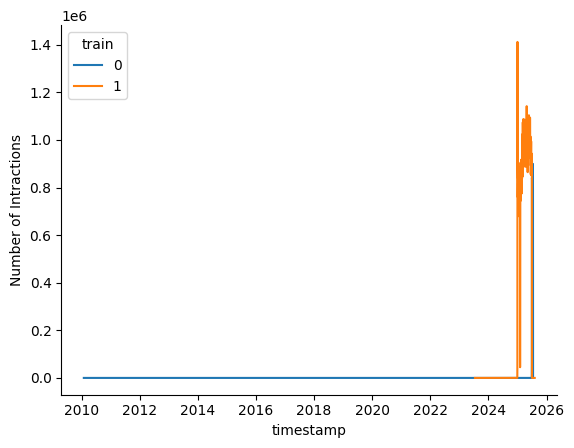

In [83]:
sns.lineplot(data=dates, x='timestamp', y='len', hue='train')
sns.despine(top=True, right=True)
plt.ylabel('Number of Intractions')
plt.show()

- There are strange cases when Train and Test Trackers data might overlap - they are very rare.

<Axes: xlabel='created_timestamp', ylabel='len'>

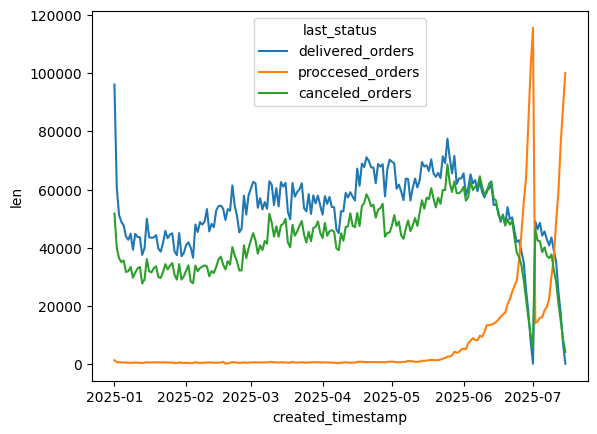

In [7]:
status = order.group_by(pl.col('created_timestamp').dt.strftime('%Y-%m-%d'), 'last_status').agg(pl.len()).collect().to_pandas()
status['created_timestamp'] = pd.to_datetime(status['created_timestamp'])

sns.lineplot(data=status, x='created_timestamp', y='len', hue='last_status')

- As close we go to the last date, the more purchases need time for transfer from processed to delivered/canceled
- Why there is a strange jump in the middle between old train and test.

# CV Establishment

- Old test data - 1 fold
- Additional 4 folds - 2 weeks each (May and June)

In [85]:
order.select(pl.max('created_timestamp')).collect()

created_timestamp
datetime[ns]
2025-07-15 23:59:59.050


In [86]:
cv_folds = [
    (pl.datetime(2025, 7, 1), pl.datetime(2025, 7, 15)),
    (pl.datetime(2025, 6, 16), pl.datetime(2025, 6, 30)),
    (pl.datetime(2025, 6, 1), pl.datetime(2025, 6, 15))
]

# Model Class

In [87]:
class BaselineModel():

    feature_schema = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_type=FeatureType.CATEGORICAL,
                feature_hint=FeatureHint.QUERY_ID,
            ),
            FeatureInfo(
                column="item_id",
                feature_type=FeatureType.CATEGORICAL,
                feature_hint=FeatureHint.ITEM_ID,
            ),
            FeatureInfo(
                column="rating",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.RATING,
            ),
            FeatureInfo(
                column="created_timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            )
        ]
    )

    def __init__(self):
        pass

    def fit(self, order):

        self.popular = (
            order
            .group_by('item_id')
            .agg(pl.len().alias('rating'))
            .sort('rating', descending=True)
            .head(100)
            .collect()
        )

    def predict(self, user_ids):

        return user_ids.join(self.popular, how='cross')

# CV scoring

In [90]:
metrics = []

for i, (start_dt, end_dt) in tqdm(enumerate(cv_folds)):
    
    train_tracker = tracker.filter(pl.col('timestamp') < start_dt)
    train_order = order.filter(pl.col('created_timestamp') < start_dt)
    
    test_order = order.filter((pl.col('created_timestamp') >= start_dt) & (pl.col('last_status') != 'canceled_orders')).unique()
    test_order = test_order.with_columns(pl.lit(1).alias('rating')).select('user_id', 'item_id', 'rating').collect()

    model = BaselineModel()
    model.fit(train_order)

    recs = model.predict(test_order.select('user_id').unique())

    metric = Experiment(
        [NDCG(100), HitRate(100)],
        test_order,
        query_column="user_id",
        item_column="item_id",
        rating_column="rating"
    )

    metric.add_result(i, recs)
    metrics.append(metric.result)

3it [00:55, 18.41s/it]


In [93]:
metrics = pd.concat(metrics, axis=0)
metrics

,NDCG@100,HitRate@100
0,0.005204,0.028892
1,0.005724,0.039800
2,0.006091,0.046480


# Submit

In [94]:
model = BaselineModel()
model.fit(train_order)

In [98]:
predict = model.predict(test_df.collect())

In [100]:
predict.group_by('user_id').agg(pl.len()).select('len').to_series().value_counts()

len,count
u32,u32
100,470347


In [103]:
result = (
    predict
    .sort(['user_id', 'rating'], descending=[False, True])  # Sort by user then rating descending
    .group_by('user_id')
    .agg(
        pl.col('item_id')
        .head(100)  # Take top 100 items per user
        .sort(descending=True)  # Sort items in descending order (optional)
        .cast(pl.Utf8)  # Convert to string for joining
        .str.concat(' ')  # Join with space
        .alias('item_id_1 item_id_2 ... item_id_100')
    )
)

/tmp/ipykernel_63539/3939865480.py:10: DeprecationWarning: `str.concat` is deprecated; use `str.join` instead. Note also that the default `delimiter` for `str.join` is an empty string, not a hyphen.
  .str.concat(' ')  # Join with space


In [1]:
predict

NameError: name 'predict' is not defined